# Libraries and Dataset

In [ ]:
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import subprocess
import os
from PIL import Image
import os
import xarray as xr
from matplotlib.pyplot import imshow, figure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ds = xr.open_mfdataset('/content/drive/MyDrive/data/df_2004_2021.nc')

In [ ]:
sdd = ds.loc[dict(Date=slice('2015-11-15', '2020-11-15'))]

In [ ]:
my_df = sdd['TMAX'].values

In [ ]:
my_df.shape

(1828, 50, 94)

# Simple LRMC (SiLRMC)

In [ ]:
def SVTC(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = False)
    idx = np.sum(s > tau)
    return u[:, : idx] @ np.diag(s[: idx] - tau) @ v[: idx, :]

def SiLRMC(mat, rho0, epsilon, maxiter):
    dim1, dim2 = mat.shape
    pos_missing = np.where(mat == 0)
    last_mat = mat.copy()
    snorm = np.linalg.norm(mat, 'fro')
    T = np.zeros((dim1, dim2))
    Z = mat.copy()
    Z[pos_missing] = np.mean(Z[Z != 0])
    it = 0
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        X = SVTC(Z - T / rho, 1 / rho)
        Z[pos_missing] = (X + T / rho)[pos_missing]
        T = T + rho * (X - Z)
        tol = np.linalg.norm((X - last_mat), 'fro') / snorm
        last_mat = X.copy()
        it += 1
        if it % 50 == 0:
            print('Iter: {}'.format(it))
            print('Norm Error: {:.6}'.format(tol))
            print()
        if (tol < epsilon) or (it >= maxiter):
            break
    return X

In [ ]:
# def scale_to_data(vec, alpha):
#     dim = vec.shape[0]
#     new_vec = np.zeros(dim)
#     for i in range(dim):
#         new_vec[i] = vec[i] * np.exp((i + 1) * alpha / 2)
#     return new_vec

# def scale_back_data(vec, alpha):
#     dim = vec.shape[0]
#     new_vec = np.zeros(dim)
#     for i in range(dim):
#         new_vec[i] = vec[i] * np.exp(- (i + 1) * alpha / 2)
#     return new_vec

# hankelization and inverse hankelization

In [ ]:
def hankel(vec, window_length):
    column_num = vec.shape[0] - window_length + 1
    hankel_mat = np.zeros((window_length, column_num))
    for i in range(window_length):
        hankel_mat[i, :] = vec[i : column_num + i]
    return hankel_mat

def hankel2vec(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim1, dim1 + dim2 - 1))
    for i in range(dim1):
        new_mat[i, i : dim2 + i] = mat[i, :]
    return np.true_divide(new_mat.sum(0), (new_mat != 0).sum(0))

In [ ]:
uni_X = my_df[:,1,1].reshape(-1,1)
uni_X.shape

(1828, 1)

## Scaling

In [ ]:
h= 1000; # forecast horizon
SR=0.5; # sampling rate

h_scaler = MinMaxScaler()
h_scaler = h_scaler.fit(uni_X)
uni_X_sc = h_scaler.transform(uni_X)
uni_X_sctr = uni_X_sc[:-h].copy()
vt =  uni_X_sc.reshape(-1,)

In [ ]:
vect = uni_X_sctr.reshape(-1,)
hank_X = hankel(np.append(vect, np.zeros(h)), window_length=800).T

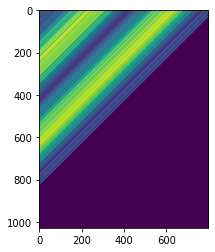

In [ ]:
plt.imshow(hank_X)

In [ ]:
uni_X_sctr.shape

(828, 1)

In [ ]:
hcX = hank_X.copy()
ind = hcX!=0
ind

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
Omega =  np.random.choice([0, 1], size=hank_X.shape, p=((1 - SR), SR)).astype(bool)

In [ ]:
Omega

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ...,  True,  True,  True],
       [False, False,  True, ..., False, False,  True],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False,  True, False, ..., False,  True, False],
       [False, False, False, ...,  True, False, False]])

In [ ]:
OmegaF = np.logical_and(Omega, ind) # removing samples along with lower triangular part corresponding to future

In [ ]:
OmegaF


array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ...,  True,  True,  True],
       [False, False,  True, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
hank_X_sp = hank_X.copy()
hank_X_sp[np.where(1-OmegaF)]= 0

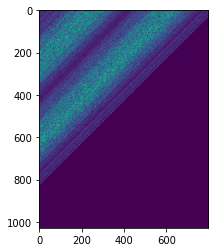

In [ ]:
plt.imshow(hank_X_sp)

In [ ]:
hank_X_sp

array([[0.34479347, 0.35171902, 0.3480089 , ..., 0.        , 0.        ,
        0.        ],
       [0.35171902, 0.3480089 , 0.        , ..., 0.25847143, 0.30027208,
        0.3371259 ],
       [0.        , 0.        , 0.33242642, ..., 0.        , 0.        ,
        0.27726935],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
rho1 = 2.3e-1
epsilon = 1e-5
maxiter = 100
lambda0 = 2 * rho1
sparse_mat=hank_X_sp.copy()
xout1 = SiLRMC(sparse_mat, rho1, epsilon, maxiter)

Iter: 50
Norm Error: 0.00134474

Iter: 100
Norm Error: 0.00011233



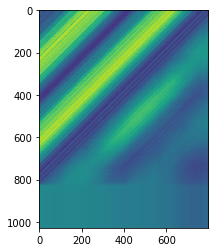

In [ ]:
plt.imshow(xout1)

# Temporal Regularized Matrix Completion



In [ ]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])
def compute_smape(act,forc):
    return 100/len(act)*np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))    

def generate_Psi(T, d):
    Psi = []
    for k in range(0, d + 1):
        if k == 0:
            Psi.append(np.append(np.zeros((T - d, d)), np.eye(T - d), axis = 1))
        else:
            Psi.append(np.append(np.append(np.zeros((T - d, d - k)), np.eye(T - d), axis = 1), 
                                 np.zeros((T - d, k)), axis = 1))
    return Psi

def update_cg(var, r, q, Aq, rold):
    alpha = rold / np.inner(q, Aq)
    var = var + alpha * q
    r = r - alpha * Aq
    rnew = np.inner(r, r)
    q = r + (rnew / rold) * q
    return var, r, q, rnew

def ell_w(ind, W, X, rho):
    return X @ ((W.T @ X) * ind).T + rho * W

def conj_grad_w(sparse_mat, ind, W, X, rho, maxiter = 5):
    rank, dim1 = W.shape
    w = np.reshape(W, -1, order = 'F')
    r = np.reshape(X @ sparse_mat.T - ell_w(ind, W, X, rho), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dim1), order = 'F')
        Aq = np.reshape(ell_w(ind, Q, X, rho), -1, order = 'F')
        w, r, q, rold = update_cg(w, r, q, Aq, rold)
    return np.reshape(w, (rank, dim1), order = 'F')

def ell_x(ind, W, X, A, Psi, d, lambda0, rho):
    rank, dim2 = X.shape
    temp = np.zeros((d * rank, Psi[0].shape[0]))
    for k in range(1, d + 1):
        temp[(k - 1) * rank : k * rank, :] = X @ Psi[k].T
    temp1 = X @ Psi[0].T - A @ temp
    temp2 = np.zeros((rank, dim2))
    for k in range(d):
        temp2 += A[:, k * rank : (k + 1) * rank].T @ temp1 @ Psi[k + 1]
    return W @ ((W.T @ X) * ind) + rho * X + lambda0 * (temp1 @ Psi[0] - temp2)

def conj_grad_x(sparse_mat, ind, W, X, A, Psi, d, lambda0, rho, maxiter = 5):
    rank, dim2 = X.shape
    x = np.reshape(X, -1, order = 'F')
    r = np.reshape(W @ sparse_mat - ell_x(ind, W, X, A, Psi, d, lambda0, rho), -1, order = 'F')
    q = r.copy()
    rold = np.inner(r, r)
    for it in range(maxiter):
        Q = np.reshape(q, (rank, dim2), order = 'F')
        Aq = np.reshape(ell_x(ind, W, Q, A, Psi, d, lambda0, rho), -1, order = 'F')
        x, r, q, rold = update_cg(x, r, q, Aq, rold)
    return np.reshape(x, (rank, dim2), order = 'F')

def tmf(dense_mat, sparse_mat, rank, d, lambda0, rho, maxiter):
    dim1, dim2 = sparse_mat.shape
    W = 0.01 * np.random.randn(rank, dim1)
    X = 0.01 * np.random.randn(rank, dim2)
    A = 0.01 * np.random.randn(rank, d * rank)
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    Psi = generate_Psi(dim2, d)
    show_iter = 100
    temp = np.zeros((d * rank, dim2 - d))
    for it in range(maxiter):
        W = conj_grad_w(sparse_mat, ind, W, X, rho)
        X = conj_grad_x(sparse_mat, ind, W, X, A, Psi, d, lambda0, rho)
        for k in range(1, d + 1):
            temp[(k - 1) * rank : k * rank, :] = X @ Psi[k].T
        A = X @ Psi[0].T @ np.linalg.pinv(temp)
        mat_hat = W.T @ X
        if (it + 1) % show_iter == 0:
            temp_hat = mat_hat[pos_test]
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            print('SMAPE: {:.6}'.format(compute_smape(dense_test, temp_hat)))
            print()
    return mat_hat, W, X, A

In [ ]:
dense_mat = hank_X.copy()
sparse_mat = hank_X_sp.copy()

In [ ]:
dim1, dim2 = dense_mat.shape
lambda0 = 0.07
rho =  5*lambda0
delta=h
rank=35
d=3
maxiter = 100
_, W, X, A = tmf(dense_mat, sparse_mat, 
                            rank, d, lambda0, rho, maxiter)

Iter: 100
MAPE: 0.162829
RMSE: 0.0710464
SMAPE: 14.6473



In [ ]:
xout2= W.T @ X

In [ ]:
xout2.shape

(1029, 800)

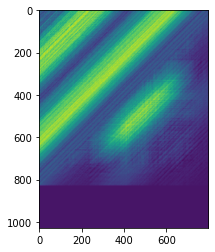

In [ ]:
plt.imshow(xout2)

## Inverse hankel

In [ ]:
vout1 = hankel2vec(xout1)
vout2 = hankel2vec(xout2)
vtr = h_scaler.inverse_transform(vt.reshape(uni_X.shape[0], uni_X.shape[1])).reshape(-1,)
vout1= h_scaler.inverse_transform(vout1.reshape(-1,1))
vout2= h_scaler.inverse_transform(vout2.reshape(-1,1))

In [ ]:
vtr.shape, vout1.shape, vout2.shape

((1828,), (1828, 1), (1828, 1))

In [ ]:
Om=hankel2vec(OmegaF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [ ]:
Om[np.where(Om==np.nan)]=0


In [ ]:
vtr2= vtr*Om;

In [ ]:
# np.isnan(vtr2).sum()


## Plots

In [ ]:
import seaborn as sns
sns.set(style='dark')

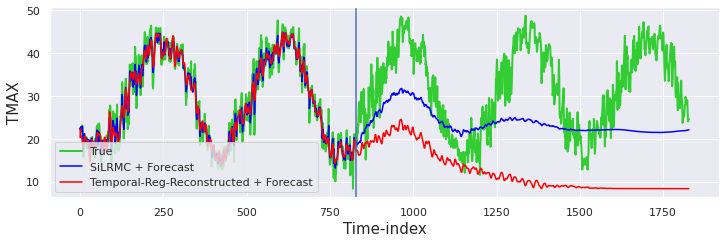

In [ ]:
plt.figure(figsize=(12,3.5))
plt.plot(vtr[:], label='True', linewidth=2, color='limegreen')
plt.plot(vout1[:], label='SiLRMC + Forecast', color = 'blue')
plt.plot(vout2[:], label='Temporal-Reg-Reconstructed + Forecast', color = 'red')
plt.axvline(x=len(uni_X)-h)
plt.xlabel('Time-index', fontdict={'fontsize': 15})
plt.ylabel('TMAX', fontdict={'fontsize': 15})
plt.grid(1)
plt.legend(loc='lower left')
# plt.title('Comparision between actual, Temporal-Reg-Forecast, SiLRMC-Forecast', fontdict={'fontsize': 18})
plt.savefig("/content/Hankel_forecast_SR_{}_h_{}.svg".format(SR, h), format="svg")


In [ ]:
sns.reset_orig()

In [ ]:
dim1, dim2 = sparse_mat.shape
dim2

800

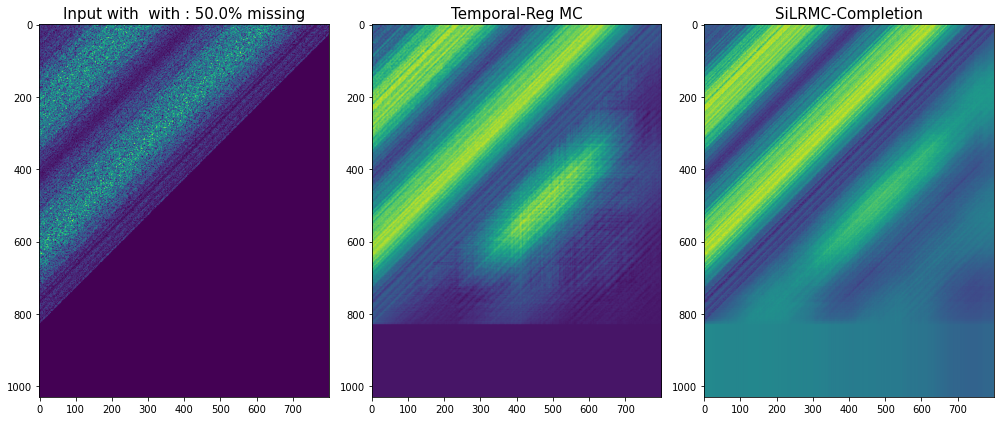

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(hank_X_sp)
plt.title("Input with  with : {}% missing".format(100-SR*100), fontdict={'fontsize': 15}) 

plt.subplot(1,3,2)
plt.imshow(xout2)
plt.title("Temporal-Reg MC", fontdict={'fontsize': 15}) 

plt.subplot(1,3,3)
plt.imshow(xout1)
plt.title("SiLRMC-Completion", fontdict={'fontsize': 15}) 

plt.subplots_adjust(wspace=0.025, hspace=0.05, left=0.05, right=0.95, bottom=0.05, top=0.95)  
plt.tight_layout()
plt.savefig("/content/Hankel_Impute_SR_{}_h_{}.svg".format(SR, h), format="svg")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 




In [ ]:
SMAPE = compute_smape(vtr[-h:], vout1[-h:])
MAE = mean_absolute_error(vtr[-h:],vout1[-h:])
RMSE = np.sqrt(mean_squared_error(vtr[-h:],vout1[-h:]))  
RMSE, MAE, SMAPE

(11.77233144234139, 9.560153661629046, 35698.24748655935)

In [ ]:
SMAPE = compute_smape(vtr[-h:], vout2[-h:])
MAE = mean_absolute_error(vtr[-h:],vout2[-h:])
RMSE = np.sqrt(mean_squared_error(vtr[-h:],vout2[-h:]))  
RMSE, MAE, SMAPE

(21.760808620363214, 19.272724471877687, 86063.15653497312)